In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import datetime
from scipy.stats import norm
import plotly.express as px

In [2]:
# 1. Fetch recent S&P 500 price
ticker = '^GSPC'
data = yf.download(ticker, period='1d')
S0 = data['Close'].iloc[-1]

# 2. Risk-free rate using pandas_datareader (Fed Funds Rate from FRED)
def get_risk_free_rate():
    start_date = datetime.datetime.now() - datetime.timedelta(days=30)  # Last 30 days
    end_date = datetime.datetime.now()
    fred_data = pdr.get_data_fred('DFF', start=start_date, end=end_date)
    rate = fred_data['DFF'].iloc[-1] / 100  # Last available rate and convert to decimal
    return rate

# Get the current risk-free rate
r = get_risk_free_rate()

[*********************100%***********************]  1 of 1 completed


In [15]:
# 3. Option parameters
strike_price = 6500  # Example strike price
T = 1.0  # Time to maturity (1 year)
sigma = 0.20  # Estimated volatility (20%)
N = 1000000  # Number of simulations
steps = 52  # Weekly steps for 1 year

# 4. Monte Carlo Simulation with Weekly Steps for European Call Option Pricing
dt = T / steps  # Time increment per step
np.random.seed(42)

# Create a DataFrame to store the entire path of simulated stock prices
# Initialize with the initial stock price S0
simulated_paths = pd.DataFrame(np.zeros((N, steps + 1)))
simulated_paths.iloc[:, 0] = S0


# Simulate the stock prices for each path over the defined number of steps
for step in range(1, steps + 1):
    Z = np.random.normal(0, 1, N)
    # Update stock price for each simulation path and store in the corresponding column
    simulated_paths.iloc[:, step] = simulated_paths.iloc[:, step - 1] * \
                                    np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)


# The last column represents the final stock prices at maturity
ST = simulated_paths.iloc[:, -1]

In [16]:
# 5. Payoff calculation from the last step (maturity)
payoff = np.maximum(ST - strike_price, 0)  # Call option payoff based on final stock prices

# 6. Discounted average payoff
C0 = np.exp(-r * T) * np.mean(payoff)

# 7. Results
print(f"S&P 500 Current Price: {S0:.2f}")
print(f"Risk-Free Rate: {r * 100:.2f}%")
print(f"European Call Option Price with Weekly Steps: ${C0:.2f}")

S&P 500 Current Price: 5718.57
Risk-Free Rate: 4.83%
European Call Option Price with Weekly Steps: $273.47


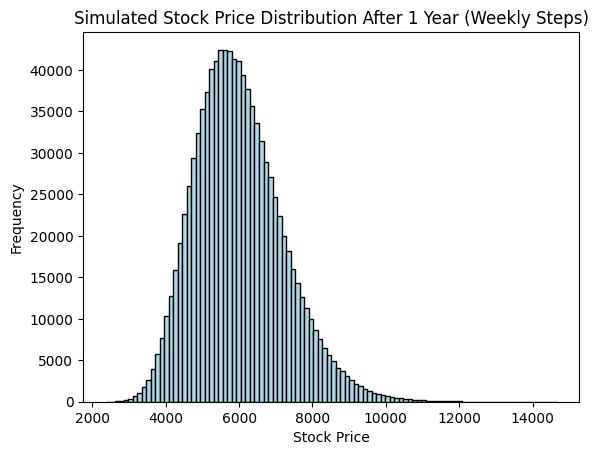

In [17]:
# 8. Visualize the final stock prices distribution
plt.hist(ST, bins=100, color='lightblue', edgecolor='black')
plt.title('Simulated Stock Price Distribution After 1 Year (Weekly Steps)')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.show()

In [19]:
# 9. Visualize the Simulated path for 1000 simulations
fig = px.line(simulated_paths.iloc[:1000,:].T, 
              title='Simulated Paths',
              labels={'index': 'Time Steps', 'value': 'Values'})

# Show the plot
fig.show()